# Análise de Preços do S&P 500

Este notebook aborda a análise dos preços do S&P 500. Vamos realizar uma análise exploratória dos dados, seguida pelo treinamento de modelos de séries temporais e avaliação de seus desempenhos.


In [64]:
import matplotlib
import numpy
import pandas
import statsmodels
import xgboost
import yfinance
import pmdarima
import prophet
import sklearn

print("matplotlib.__version__: ", matplotlib.__version__)
print("numpy.__version__: ", numpy.__version__)
print("pandas.__version__: ", pandas.__version__)
print("statsmodels.__version__: ", statsmodels.__version__)
print("xgboost.__version__: ", xgboost.__version__)
print("yfinance.__version__: ", yfinance.__version__)
print("pmdarima.__version__: ", pmdarima.__version__)
print("prophet.__version__: ", prophet.__version__)
print("sklearn.__version__: ", sklearn.__version__)

matplotlib.__version__:  3.9.2
numpy.__version__:  1.26.4
pandas.__version__:  2.2.2
statsmodels.__version__:  0.14.2
xgboost.__version__:  2.1.1
yfinance.__version__:  0.2.43
pmdarima.__version__:  2.0.4
prophet.__version__:  1.1.5
sklearn.__version__:  1.5.1


- matplotlib.__version__:  3.9.2
- numpy.__version__:  1.26.4
- pandas.__version__:  2.2.2
- statsmodels.__version__:  0.14.2
- xgboost.__version__:  2.1.1
- yfinance.__version__:  0.2.43
- pmdarima.__version__:  2.0.4
- prophet.__version__:  1.1.5
- sklearn.__version__:  1.5.1

In [66]:
print(f"""
      pip install numpy=={numpy.__version__}
      pip install pandas=={pandas.__version__}
      pip install statsmodels=={statsmodels.__version__}
      pip install xgboost=={xgboost.__version__}
      pip install yfinance=={yfinance.__version__}
      pip install pmdarima=={pmdarima.__version__}
      pip install prophet=={prophet.__version__}
      pip install sklearn=={sklearn.__version__}
      """)


      pip install numpy==1.26.4
      pip install pandas==2.2.2
      pip install statsmodels==0.14.2
      pip install xgboost==2.1.1
      pip install yfinance==0.2.43
      pip install pmdarima==2.0.4
      pip install prophet==1.1.5
      pip install sklearn==1.5.1
      


In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xgboost as xgb
import yfinance as yf
import pmdarima as pm
from prophet import Prophet
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)
from statsmodels.tsa.seasonal import seasonal_decompose

In [28]:
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore")

### Métricas de avaliação dos modelos

In [29]:
# Funções de Avaliação
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return mae, mse, mape


def print_metrics(metrics):
    mae, mse, mape = metrics
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape:.2f} %")

## 1. Coleta de Dados

In [30]:
# Coletando Dados do S&P 500
ticker = "SPY"
data = yf.download(ticker, start="2010-01-01", end="2024-09-11")
data = data[["Open", "Close"]]
data.reset_index(inplace=True)
data["Date"] = pd.to_datetime(data["Date"])

# Exibindo os primeiros registros
data.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,Close
0,2010-01-04,112.370003,113.330002
1,2010-01-05,113.260002,113.629997
2,2010-01-06,113.519997,113.709999
3,2010-01-07,113.500000,114.190002
4,2010-01-08,113.889999,114.570000


In [31]:
data.tail()

,Date,Open,Close
3691,2024-09-04,550.200012,550.950012
3692,2024-09-05,550.890015,549.609985
3693,2024-09-06,549.940002,540.359985
3694,2024-09-09,544.650024,546.409973
3695,2024-09-10,548.359985,548.789978


## 2. Análise Exploratória dos Dados

### Visualização dos Dados

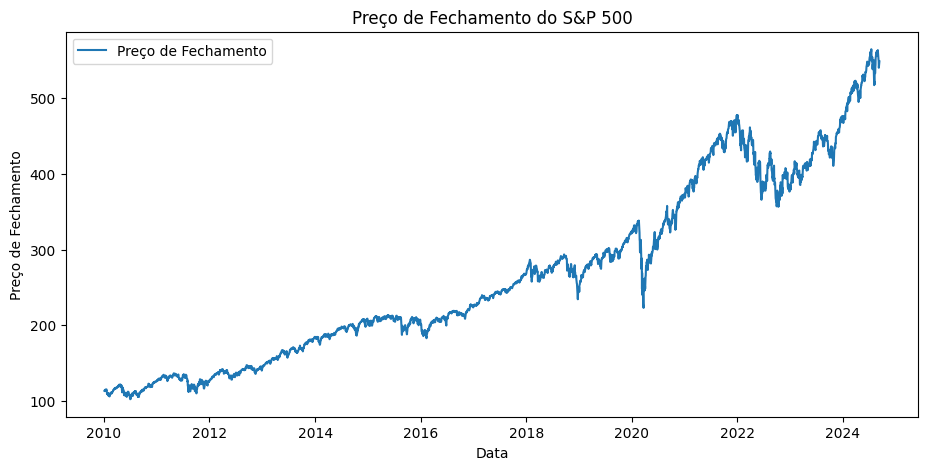

In [35]:
# Visualização dos dados
plt.figure(figsize=(11, 5))
plt.plot(data["Date"], data["Close"], label="Preço de Fechamento")
plt.title("Preço de Fechamento do S&P 500")
plt.xlabel("Data")
plt.ylabel("Preço de Fechamento")
plt.legend()
plt.show()

### Decomposição da Série Temporal

In [36]:
result = seasonal_decompose(data["Close"], model="multiplicative", period=365)

<Axes: >

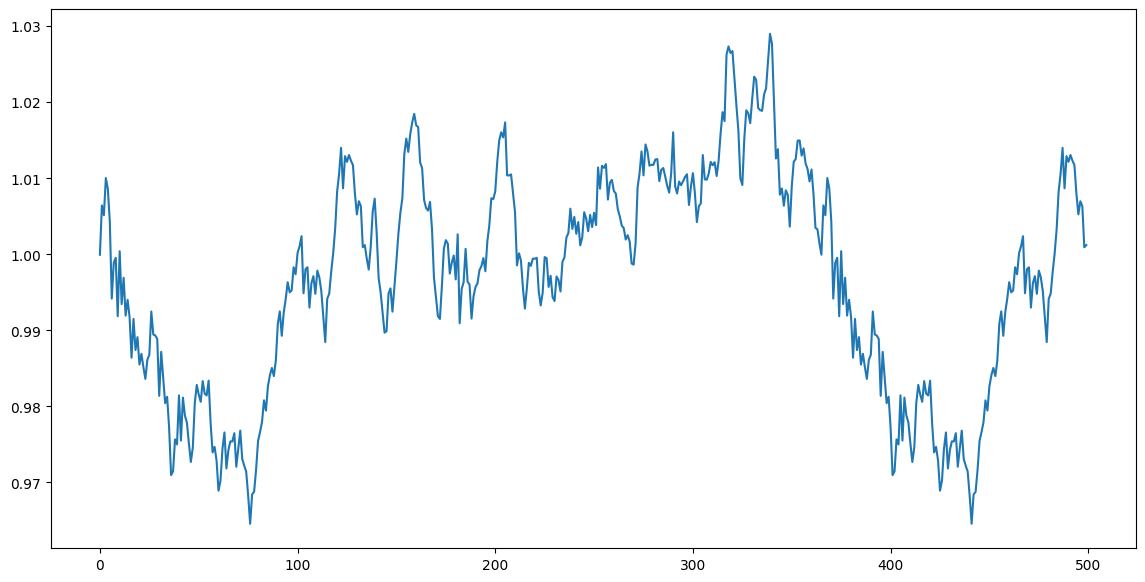

In [37]:
result.seasonal.iloc[:500].plot(figsize=(14, 7))

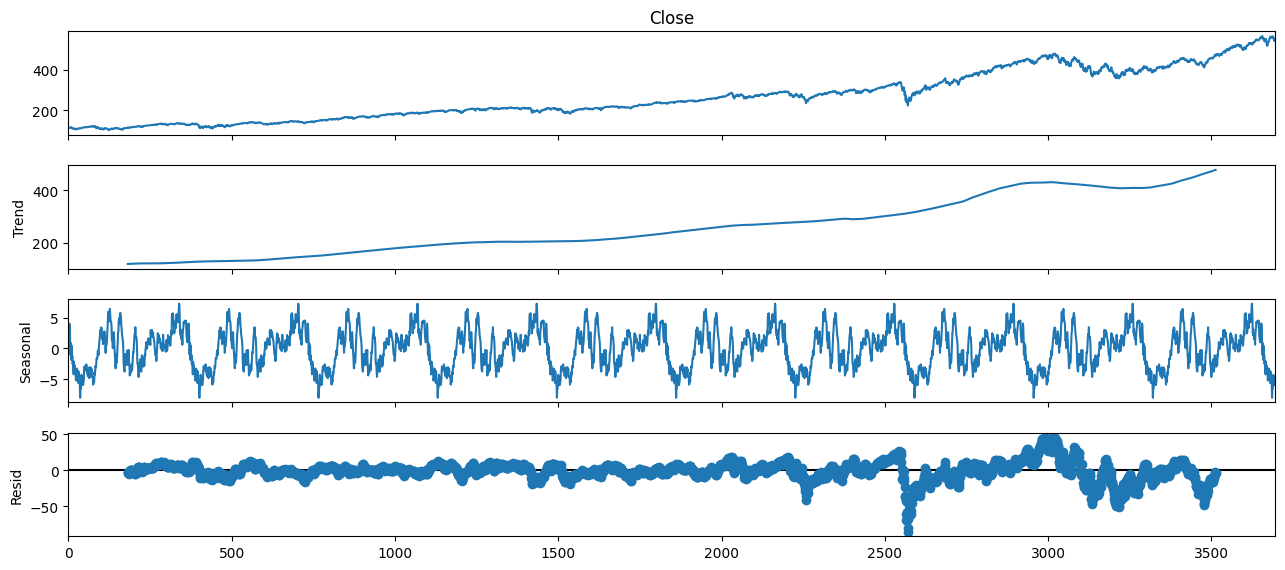

In [39]:
# Decomposição da série temporal
result = seasonal_decompose(data["Close"], model="additive", period=365)
fig = result.plot()
fig.set_size_inches(14, 6)

### Decomposição autoregressiva

##### Auto correlação

In [40]:
# acf
from statsmodels.graphics.tsaplots import plot_acf as _plot_acf


def plot_acf(data, lags=365, title="Autocorrelação da Série Temporal"):

    fig, ax = plt.subplots(figsize=(15, 5))
    # Get the ACF values and confidence intervals
    _plot_acf(data, lags=lags, ax=ax, alpha=0.05)
    ax.set_title(title)
    ax.set_xlabel("Lags")
    ax.set_ylabel("Autocorrelação")
    fig.set_tight_layout(True)

    acf_x = sm.tsa.acf(data, alpha=0.05, nlags=365)
    acf, ci = acf_x[:2]
    intercept_point = np.where(abs(acf) < (ci[:, 1] - acf))
    if intercept_point[0].size > 0:
        print(
            f"The ACF coefficients intercept the threshold at lag {intercept_point[0][0]}"
        )
    else:
        print("The ACF coefficients do not intercept the threshold")

The ACF coefficients intercept the threshold at lag 322


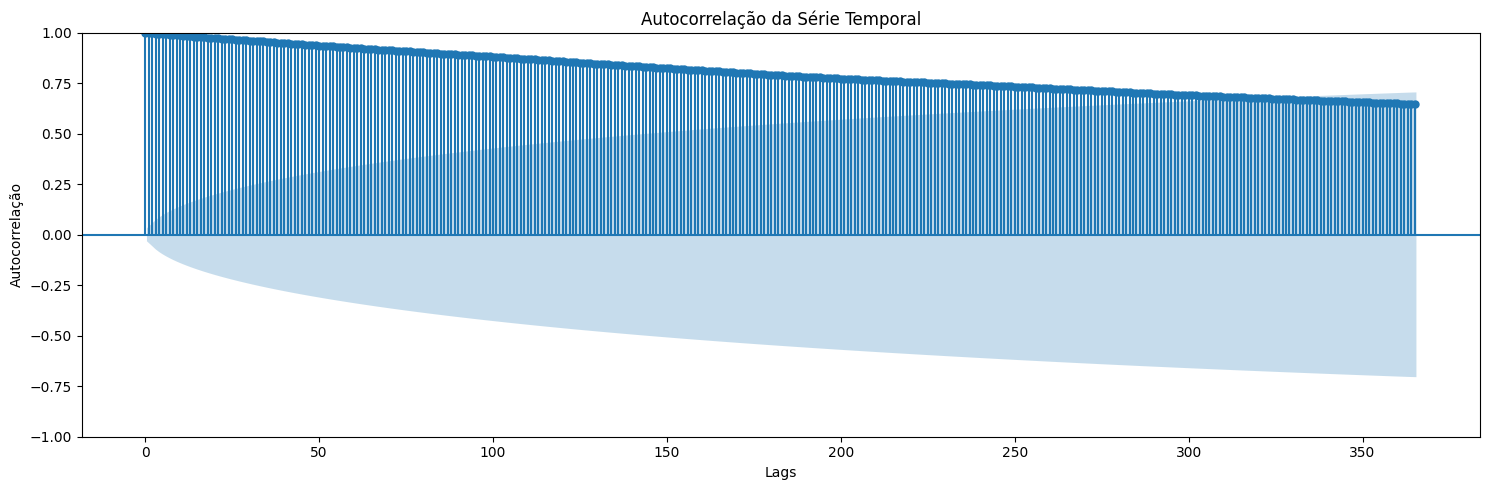

In [41]:
plot_acf(data["Close"])

##### Auto correlação parcial

In [44]:
# acf
from statsmodels.graphics.tsaplots import plot_pacf as _plot_pacf


def plot_pacf(data, lags=30, title="Autocorrelação Parcial da Série Temporal"):

    fig, ax = plt.subplots(figsize=(15, 5))
    # Get the ACF values and confidence intervals
    _plot_pacf(data, lags=lags, ax=ax, alpha=0.05)
    ax.set_title(title)
    ax.set_xlabel("Lags")
    ax.set_ylabel("Autocorrelação Parcial")
    fig.set_tight_layout(True)

    acf_x = sm.tsa.pacf(data, alpha=0.05, nlags=lags)
    acf, ci = acf_x[:2]
    intercept_point = np.where(abs(acf) < (ci[:, 1] - acf))
    if intercept_point[0].size > 0:
        print(
            f"The PACF coefficients intercept the threshold at lag {intercept_point[0][0]}"
        )
    else:
        print("The PACF coefficients do not intercept the threshold")

The PACF coefficients intercept the threshold at lag 2


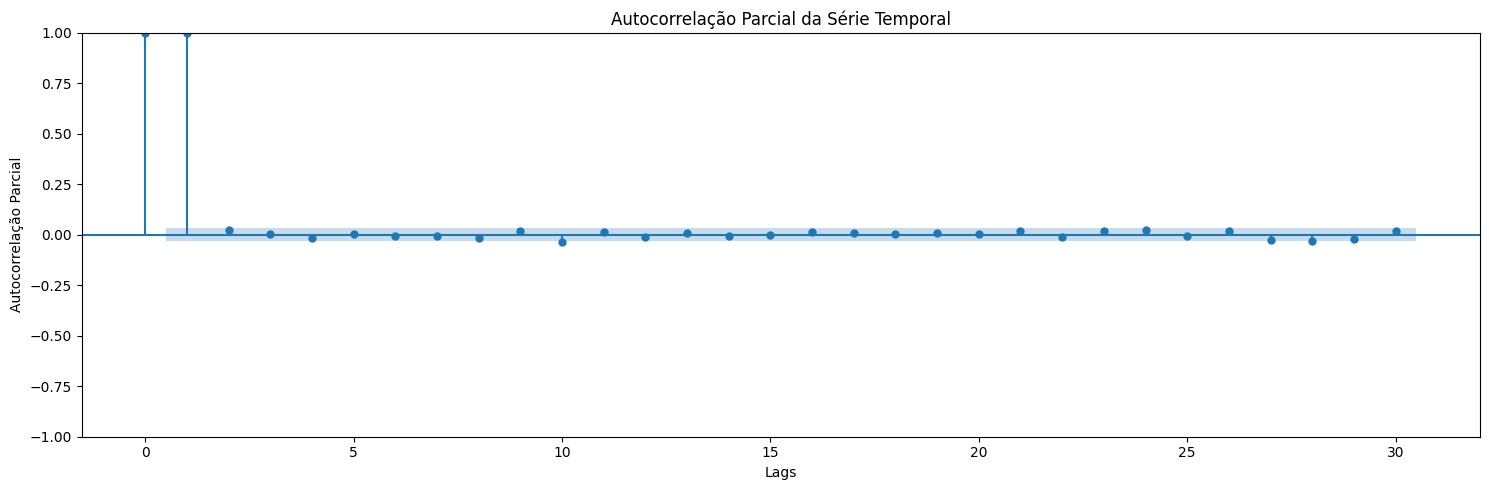

In [45]:
plot_pacf(data["Close"])

#### Diferenciação para estacionariedade

In [46]:
adf_result = sm.tsa.adfuller(data["Close"])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values: {adf_result[4]}")

if adf_result[1] < 0.05:
    print("A série temporal é estacionária")
else:
    print("A série temporal não é estacionária")

ADF Statistic: 0.8492412676847023
p-value: 0.9923908368324685
Critical Values: {'1%': -3.4321340464121652, '5%': -2.8623282926072906, '10%': -2.567189619905243}
A série temporal não é estacionária


<Axes: >

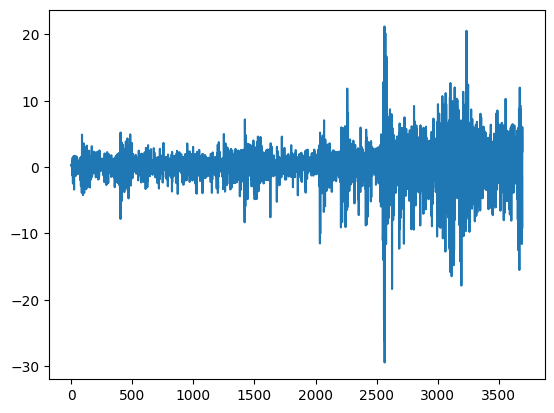

In [47]:
data["Close"].diff().plot()

In [48]:
# diferenciando 1 vez

adf_result = sm.tsa.adfuller(data["Close"].diff().dropna())
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values: {adf_result[4]}")

if adf_result[1] < 0.05:
    print("A série temporal é estacionária")
else:
    print("A série temporal não é estacionária")

ADF Statistic: -12.793367331559862
p-value: 6.999612546611123e-24
Critical Values: {'1%': -3.4321340464121652, '5%': -2.8623282926072906, '10%': -2.567189619905243}
A série temporal é estacionária


#### Coeficientes de autoregressão

In [49]:
acf_x = sm.tsa.acf(data["Close"], alpha=0.05, nlags=365)
acf, ci = acf_x[:2]
# identificação do q pelo ponto de interceptação ao 95% com o acf
q = np.where(abs(acf) < (ci[:, 1] - acf))[0][0]

pacf_x = sm.tsa.pacf(data["Close"], alpha=0.05, nlags=30)
pacf, ci = pacf_x[:2]
# identificação do p pelo ponto de interceptação ao 95% com o pacf
p = np.where(abs(pacf) < (ci[:, 1] - pacf))[0][0]

d = 1  # apenas 1 diferenciação foi necessária para tornar a série estacionária

In [50]:
# parâmetros do modelo ARIMA
p, q, d

(2, 322, 1)

#### Determinando os parâmetros de sazonalidade

In [51]:
model = pm.auto_arima(
    data["Close"],
    seasonal=True,
    m=12,
    stepwise=True,
)

# Summary of the model's detected parameters
print(model.summary())

# Detected seasonal order
seasonal_order = model.seasonal_order
print(f"Detected Seasonal Order: {seasonal_order}")

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3696
Model:               SARIMAX(2, 1, 0)   Log Likelihood               -9409.190
Date:                Thu, 12 Sep 2024   AIC                          18826.380
Time:                        19:59:05   BIC                          18851.239
Sample:                             0   HQIC                         18835.227
                               - 3696                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1228      0.053      2.303      0.021       0.018       0.227
ar.L1         -0.0680      0.008     -8.828      0.000      -0.083      -0.053
ar.L2          0.0256      0.007      3.601      0.0

## 3. Preparação dos Dados e Modelagem

### Dividindo os Dados em Treino e Teste

In [52]:
# Dividindo em treino e teste

train_size = data.shape[0] - 7
train, test = data[:train_size], data[train_size:]


# Preparação dos dados para XGBoost
def create_features(df):
    df["Date"] = pd.to_datetime(df["Date"])
    df["year"] = df["Date"].dt.year
    df["month"] = df["Date"].dt.month
    df["day"] = df["Date"].dt.day
    df["dayofweek"] = df["Date"].dt.dayofweek
    return df


train = create_features(train)
test = create_features(test)

FEATURES = ["year", "month", "day", "dayofweek", "Open"]
TARGET = "Close"

### Modelo XGBoost

In [53]:
# Modelo XGBoost
X_train, y_train = train[FEATURES], train[TARGET]
X_test, y_test = test[FEATURES], test[TARGET]

reg = xgb.XGBRegressor(objective="reg:squarederror")
reg.fit(X_train, y_train)

# Avaliação XGBoost
preds = reg.predict(X_test)
metrics_xgb = calculate_metrics(y_test, preds)
print("XGBoost Metrics:")
print_metrics(metrics_xgb)

XGBoost Metrics:
MAE: 4.256216866629464
MSE: 28.504805034292595
MAPE: 0.78 %


In [54]:
f"{100 - 0.78: .2f}%"

' 99.22%'

### Modelo Prophet

In [55]:
# Modelo Prophet
train_prophet = train.rename(columns={"Date": "ds", "Close": "y"})
test_prophet = test.rename(columns={"Date": "ds", "Close": "y"})

model = Prophet(daily_seasonality=True)
model.add_regressor("Open")
model.fit(train_prophet)

future = model.make_future_dataframe(periods=len(test))
future["Open"] = pd.concat([train["Open"], test["Open"]], ignore_index=True)
forecast = model.predict(future)

preds = forecast[["ds", "yhat"]].tail(len(test))
preds = preds.set_index("ds")
y_test = test_prophet.set_index("ds")["y"]

metrics_pr = calculate_metrics(y_test, preds["yhat"])
print("Prophet Metrics:")
print_metrics(metrics_pr)

20:32:00 - cmdstanpy - INFO - Chain [1] start processing
20:32:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet Metrics:
MAE: 7.2292753363391125
MSE: 102.75903370167396
MAPE: 1.31 %


### Modelo SARIMAX

In [56]:
p, d, q

(2, 1, 322)

In [60]:
# Modelo SARIMAX
exog_train = train[["Open"]]
exog_test = test[["Open"]]

model = sm.tsa.statespace.SARIMAX(
    train["Close"],
    exog=exog_train,
    order=(
        p,
        d,
        1,
    ),  # q muito grande faz com que o modelo fique muito complexo e lento
    seasonal_order=(0, 0, 0, 12),
)
results = model.fit()

preds = results.get_forecast(steps=len(test), exog=exog_test).predicted_mean

metrics_sarimax = calculate_metrics(test["Close"], preds)
print("SARIMAX Metrics:")
print_metrics(metrics_sarimax)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.40852D+00    |proj g|=  2.69069D-01


 This problem is unconstrained.



At iterate    5    f=  2.31976D+00    |proj g|=  1.27217D-01

At iterate   10    f=  2.29284D+00    |proj g|=  4.14302D-02

At iterate   15    f=  2.27828D+00    |proj g|=  2.12982D-02

At iterate   20    f=  2.27432D+00    |proj g|=  1.38209D-01

At iterate   25    f=  2.27372D+00    |proj g|=  8.61680D-03

At iterate   30    f=  2.27351D+00    |proj g|=  1.06641D-02

At iterate   35    f=  2.27349D+00    |proj g|=  1.01344D-02

At iterate   40    f=  2.27344D+00    |proj g|=  1.14291D-02

At iterate   45    f=  2.27344D+00    |proj g|=  1.60279D-03

At iterate   50    f=  2.27344D+00    |proj g|=  1.51501D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [58]:
f"{100 - 0.65: .2f}%"

' 99.35%'

# Comparando modelos

In [61]:
df = pd.DataFrame(
    [metrics_xgb, metrics_pr, metrics_sarimax],
    columns=["MAE", "MSE", "MAPE"],
    index=["XGBoost", "Prophet", "SARIMAX"],
)
df.sort_values(by="MAPE", ascending=True)

,MAE,MSE,MAPE
SARIMAX,3.562864,25.380242,0.650043
XGBoost,4.256217,28.504805,0.775951
Prophet,7.229275,102.759034,1.314659


In [ ]:
mae = np.mean(np.abs(y_test - preds))
mse = np.mean((y_test - preds) ** 2)
mape = np.mean(np.abs((y_test - preds) / y_test)) * 100

In [62]:
np.__version__

'1.26.4'

## Conclusão

Neste notebook, realizamos uma análise detalhada dos preços do S&P 500. Após a análise exploratória, treinamos e avaliamos três modelos de séries temporais: XGBoost, Prophet e SARIMAX. As métricas de desempenho dos modelos foram calculadas para comparar sua eficácia na previsão dos preços de fechamento.